## Zahra's code

In [4]:
import numpy as np
import tifffile as tif
# import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
%matplotlib inline
# from skimage.morphology import ball

In [2]:
#first, make a map of cells
pth = "/jukebox/wang/zahra/h129_contra_vs_ipsi/pma_to_aba/20180410_jg52_bl6_lob7_05/posttransformed_zyx_voxels.npy"
converted_points = np.load(pth)

zyx = np.asarray([(int(xx[0]), int(xx[1]), int(xx[2])) for xx in converted_points]) #cells are counted in horizontal volumes

In [11]:
#read registered volume
vol = "/jukebox/wang/zahra/h129_contra_vs_ipsi/reg_to_allen/20180410_jg52_bl6_lob7_05/cell_to_reg/result.tif"
img = tif.imread(vol)  

KeyboardInterrupt: 

In [13]:
cell_map = tif.imread("/jukebox/wang/ahoag/neuroglancer/registered_cellmap_test.tif")

In [14]:
zplane_map = cell_map[150]

In [19]:
zplane_map_floats = zplane_map.astype(float)

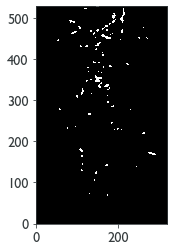

In [35]:
from scipy import misc
fig = plt.figure()
plt.gray()  # show the filtered result in grayscale
# ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(111)  # right side
result = gaussian_filter(cell_map, sigma=2)
result[result>0.5] = 1
result[result<=0.5] = 0
result_int = result.astype('uint16')
# ax1.imshow(zplane_map_floats)
ax2.imshow(result_int)

In [16]:
result

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [10]:
#apply x y dilation
r = 2
selem = ball(r)[int(r/2)]
cell_map = np.asarray([cv2.dilate(cell_map[i], selem, iterations = 1) for i in range(cell_map.shape[0])])

In [14]:
tif.imsave("/home/ahoag/ngdemo/data/registered_cellmap_test.tif", cell_map)

In [23]:
# Now create the cloudvolume for this tif file
import os
import numpy as np

from concurrent.futures import ProcessPoolExecutor

from taskqueue import LocalTaskQueue
import igneous.task_creation as tc


from cloudvolume import CloudVolume
from cloudvolume.lib import mkdir, touch
from PIL import Image

ModuleNotFoundError: No module named 'taskqueue'

In [7]:
cell_map_filename = "/home/ahoag/ngdemo/data/registered_cellmap_test.tif"
cell_map = tif.imread(cell_map_filename)
cell_map.shape # z,y,x

(456, 528, 320)

In [10]:
home_dir = '/home/ahoag/ngdemo'
progress_dir = mkdir(home_dir + '/label_progress_regcells/')
def make_info_file():
    info = CloudVolume.create_new_info(
        num_channels = 1,
        layer_type = 'segmentation', # 'image' or 'segmentation'
        data_type = 'uint16', # can pick any popular uint
        encoding = 'raw', # other options: 'jpeg', 'compressed_segmentation' (req. uint32 or uint64)
        resolution = [ 40000, 40000, 40000 ], # X,Y,Z values in nanometers, 40 microns in each dim
        voxel_offset = [ 0, 0, 1 ], # values X,Y,Z values in voxels
        chunk_size = [ 1024, 1024, 1 ], # rechunk of image X,Y,Z in voxels
        volume_size = [320,528,456], # X,Y,Z size in voxels
    )

    # If you're using amazon or the local file system, you can replace 'gs' with 's3' or 'file'
    vol = CloudVolume('file:///home/ahoag/ngdemo/demo_bucket/demo_dataset/registered_cells', info=info)
    vol.provenance.description = "A demo to show cells registered to the allen atlas"
    vol.provenance.owners = ['ahoag@princeton.edu'] # list of contact email addresses

    vol.commit_info() # generates gs://bucket/dataset/layer/info json file
    vol.commit_provenance() # generates gs://bucket/dataset/layer/provenance json file
    return vol

In [11]:
def process_slice(z):
    print('Processing slice z=',z)
    
    array = cell_map[z-1].reshape((1,y_dim,x_dim)).T

    cloud_vol[:,:, z] = array
    touch(os.path.join(progress_dir, str(z)))

In [12]:
 cloud_vol = make_info_file()
""" tifffile is already loaded """
# image = np.array(tifffile.imread(brainvolume_file),dtype=np.uint16, order='F') # F stands for fortran order
z_dim,y_dim,x_dim = cell_map.shape

done_files = set([ int(z) for z in os.listdir(progress_dir) ])
all_files = set(range(cloud_vol.bounds.minpt.z, cloud_vol.bounds.maxpt.z)) # 1 indexed 

to_upload = [ int(z) for z in list(all_files.difference(done_files)) ]
to_upload.sort()
# print("Remaining slices to upload are:",to_upload)

with ProcessPoolExecutor(max_workers=8) as executor:
    executor.map(process_slice, to_upload)

Remaining slices to upload are: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 

Uploading: 100%|██████████| 1/1 [00:00<00:00, 72.94it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s].85it/s]

Processing slice z= 9





Uploading: 100%|██████████| 1/1 [00:00<00:00, 74.70it/s]

Processing slice z= 10


Processing slice z= 11


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 65.60it/s]

Processing slice z= 12



Uploading: 100%|██████████| 1/1 [00:00<00:00, 75.51it/s]

Processing slice z= 13


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 14


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 15


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 16



Uploading:   0%|          | 0/1 [00:00<?, ?it/s].55it/s]

Processing slice z= 17




Uploading: 100%|██████████| 1/1 [00:00<00:00, 49.17it/s]



Processing slice z= 18


Uploading: 100%|██████████| 1/1 [00:00<00:00, 182.83it/s]



Processing slice z= 19



Uploading: 100%|██████████| 1/1 [00:00<00:00, 45.24it/s]






Processing slice z= 20


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 21


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 22
Processing slice z= 23
Processing slice z= 24



Uploading: 100%|██████████| 1/1 [00:00<00:00, 119.92it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 55.37it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 111.65it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 25


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 55.65it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 26
Processing slice z= 27


Processing slice z= 28


Uploading: 100%|██████████| 1/1 [00:00<00:00, 78.57it/s]

Processing slice z= 29



Uploading: 100%|██████████| 1/1 [00:00<00:00, 284.34it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 30





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 31


Uploading: 100%|██████████| 1/1 [00:00<00:00, 89.59it/s]

Processing slice z= 32


Processing slice z= 33


Uploading: 100%|██████████| 1/1 [00:00<00:00, 89.37it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00, 101.99it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 158.24it/s]




Processing slice z= 34


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 35


Processing slice z= 36
Processing slice z= 37


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 38


Uploading: 100%|██████████| 1/1 [00:00<00:00, 73.12it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 39


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 71.39it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 93.64it/s]

Processing slice z= 40



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 41




Uploading: 100%|██████████| 1/1 [00:00<00:00, 75.06it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 42



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 43



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 44


Uploading: 100%|██████████| 1/1 [00:00<00:00, 73.19it/s]


Processing slice z= 45


Uploading: 100%|██████████| 1/1 [00:00<00:00, 105.24it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 46


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 47


Uploading: 100%|██████████| 1/1 [00:00<00:00, 76.49it/s]


Processing slice z= 48



Uploading: 100%|██████████| 1/1 [00:00<00:00, 95.37it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00, 93.18it/s]




Processing slice z= 49



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 50


Uploading: 100%|██████████| 1/1 [00:00<00:00, 149.21it/s]


Processing slice z= 51


Processing slice z= 52
Processing slice z= 53


Uploading: 100%|██████████| 1/1 [00:00<00:00, 108.80it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 54
Processing slice z= 55


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 62.97it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 56



Uploading: 100%|██████████| 1/1 [00:00<00:00, 62.87it/s]]


Processing slice z= 57



Uploading: 100%|██████████| 1/1 [00:00<00:00, 52.79it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00, 65.86it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 58


Processing slice z= 59


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 60


Processing slice z= 61


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 62



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 63


Uploading: 100%|██████████| 1/1 [00:00<00:00, 48.05it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 46.22it/s]


Processing slice z= 64


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00, 38.60it/s]


Processing slice z= 65


Uploading: 100%|██████████| 1/1 [00:00<00:00, 79.31it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 66


Processing slice z= 67


Uploading: 100%|██████████| 1/1 [00:00<00:00, 60.83it/s]



Processing slice z= 68


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 69


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 70



Uploading: 100%|██████████| 1/1 [00:00<00:00, 66.60it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 71


Uploading: 100%|██████████| 1/1 [00:00<00:00, 54.77it/s]


Processing slice z= 72



Uploading: 100%|██████████| 1/1 [00:00<00:00, 87.29it/s]


Processing slice z= 73



Uploading: 100%|██████████| 1/1 [00:00<00:00, 84.67it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 74


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 40.77it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Processing slice z= 75


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 76



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 77


Uploading: 100%|██████████| 1/1 [00:00<00:00, 45.62it/s]

Processing slice z= 78



Uploading: 100%|██████████| 1/1 [00:00<00:00, 49.42it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 46.74it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 79
Processing slice z= 80






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 81


Uploading: 100%|██████████| 1/1 [00:00<00:00, 69.99it/s]

Processing slice z= 83


Processing slice z= 82
Processing slice z= 84



Uploading: 100%|██████████| 1/1 [00:00<00:00, 70.65it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 85


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 86


Uploading: 100%|██████████| 1/1 [00:00<00:00, 74.14it/s]

Processing slice z= 87



Uploading: 100%|██████████| 1/1 [00:00<00:00, 53.34it/s]

Processing slice z= 88



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 89


Uploading: 100%|██████████| 1/1 [00:00<00:00, 70.96it/s]


Processing slice z= 90


Processing slice z= 91



Uploading: 100%|██████████| 1/1 [00:00<00:00, 48.72it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 92



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 93



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 94



Uploading: 100%|██████████| 1/1 [00:00<00:00, 37.04it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 95


Uploading: 100%|██████████| 1/1 [00:00<00:00, 53.96it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 96



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 97


Processing slice z= 98


Uploading: 100%|██████████| 1/1 [00:00<00:00, 57.93it/s]

Processing slice z= 99



Uploading: 100%|██████████| 1/1 [00:00<00:00, 72.75it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 100
Processing slice z= 101



Uploading:   0%|          | 0/1 [00:00<?, ?it/s].15it/s]

Processing slice z= 102



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 103




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 104


Uploading: 100%|██████████| 1/1 [00:00<00:00, 51.86it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 51.52it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 105


Uploading: 100%|██████████| 1/1 [00:00<00:00, 33.72it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Processing slice z= 106


Uploading: 100%|██████████| 1/1 [00:00<00:00, 49.43it/s]


Processing slice z= 107
Processing slice z= 109


Processing slice z= 108
Processing slice z= 110


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 111


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 112


Uploading: 100%|██████████| 1/1 [00:00<00:00, 39.66it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 44.97it/s]

Processing slice z= 113





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 114


Processing slice z= 115


Uploading: 100%|██████████| 1/1 [00:00<00:00, 45.81it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 116


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 117


Processing slice z= 118
Processing slice z= 119


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 120


Uploading: 100%|██████████| 1/1 [00:00<00:00, 35.48it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 29.71it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 19.73it/s]



Processing slice z= 121




Uploading: 100%|██████████| 1/1 [00:00<00:00, 61.61it/s]

Processing slice z= 122


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 123




Uploading: 100%|██████████| 1/1 [00:00<00:00, 46.98it/s]

Processing slice z= 124


Processing slice z= 125


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 126


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 127



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 128


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 129



Uploading: 100%|██████████| 1/1 [00:00<00:00, 33.82it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 30.82it/s]



Processing slice z= 130



Uploading: 100%|██████████| 1/1 [00:00<00:00, 40.28it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00, 41.65it/s]

Processing slice z= 131



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 132


Processing slice z= 133


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 134



Uploading: 100%|██████████| 1/1 [00:00<00:00, 42.70it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 135


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 136




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 137



Uploading: 100%|██████████| 1/1 [00:00<00:00, 30.14it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 32.39it/s]

Processing slice z= 138


Processing slice z= 139



Uploading: 100%|██████████| 1/1 [00:00<00:00, 31.98it/s]

Processing slice z= 140



Uploading: 100%|██████████| 1/1 [00:00<00:00, 37.14it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s]


Processing slice z= 141




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 143
Processing slice z= 142


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 144



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 145


Uploading: 100%|██████████| 1/1 [00:00<00:00, 45.92it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00, 44.48it/s]


Processing slice z= 146
Processing slice z= 147


Uploading: 100%|██████████| 1/1 [00:00<00:00, 38.35it/s]


Processing slice z= 148



Uploading: 100%|██████████| 1/1 [00:00<00:00, 30.40it/s]


Processing slice z= 149



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 40.56it/s]

Processing slice z= 150


Processing slice z= 151



Uploading: 100%|██████████| 1/1 [00:00<00:00, 36.12it/s]

Processing slice z= 152


Uploading: 100%|██████████| 1/1 [00:00<00:00, 45.30it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 153


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 154


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 155



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 30.63it/s]

Processing slice z= 156


Uploading: 100%|██████████| 1/1 [00:00<00:00, 31.82it/s]





Processing slice z= 157



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 158


Uploading: 100%|██████████| 1/1 [00:00<00:00, 35.77it/s]

Processing slice z= 160
Processing slice z= 159




Uploading: 100%|██████████| 1/1 [00:00<00:00, 31.67it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 161


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 162




Uploading: 100%|██████████| 1/1 [00:00<00:00, 40.19it/s]

Processing slice z= 163



Uploading: 100%|██████████| 1/1 [00:00<00:00, 32.29it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 34.05it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 164
Processing slice z= 165



Uploading: 100%|██████████| 1/1 [00:00<00:00, 40.31it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 166


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 168



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 167


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 169



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 170



Uploading: 100%|██████████| 1/1 [00:00<00:00, 25.94it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00, 38.46it/s]

Processing slice z= 171


Processing slice z= 172
Processing slice z= 173



Uploading: 100%|██████████| 1/1 [00:00<00:00, 34.40it/s]

Processing slice z= 174



Uploading: 100%|██████████| 1/1 [00:00<00:00, 34.45it/s]

Processing slice z= 175



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 176


Uploading: 100%|██████████| 1/1 [00:00<00:00, 45.88it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 48.07it/s]

Processing slice z= 177


Processing slice z= 179


Processing slice z= 178


Uploading: 100%|██████████| 1/1 [00:00<00:00, 49.66it/s]

Processing slice z= 180



Uploading: 100%|██████████| 1/1 [00:00<00:00, 30.43it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Processing slice z= 181


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 182


Uploading: 100%|██████████| 1/1 [00:00<00:00, 35.98it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 183


Uploading: 100%|██████████| 1/1 [00:00<00:00, 39.55it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 184



Uploading: 100%|██████████| 1/1 [00:00<00:00, 31.80it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 185


Uploading: 100%|██████████| 1/1 [00:00<00:00, 32.70it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 39.54it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 186



Uploading: 100%|██████████| 1/1 [00:00<00:00, 47.91it/s]



Processing slice z= 187


Processing slice z= 188



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 189


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 190


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 191


Uploading: 100%|██████████| 1/1 [00:00<00:00, 39.59it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 42.24it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00, 38.96it/s]


Processing slice z= 192
Processing slice z= 193
Processing slice z= 194


Processing slice z= 195


Uploading: 100%|██████████| 1/1 [00:00<00:00, 42.95it/s]

Processing slice z= 196



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 197


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 198


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 199



Uploading: 100%|██████████| 1/1 [00:00<00:00, 25.54it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00, 30.71it/s]

Processing slice z= 200


Uploading: 100%|██████████| 1/1 [00:00<00:00, 36.14it/s]

Processing slice z= 201


Processing slice z= 202


Uploading: 100%|██████████| 1/1 [00:00<00:00, 39.84it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 203
Processing slice z= 204


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 205
Processing slice z= 206


Uploading: 100%|██████████| 1/1 [00:00<00:00, 30.74it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Processing slice z= 207


Uploading: 100%|██████████| 1/1 [00:00<00:00, 33.13it/s]


Processing slice z= 208


Processing slice z= 209



Uploading:   0%|          | 0/1 [00:00<?, ?it/s].48it/s]


Processing slice z= 211
Processing slice z= 210


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 212



Uploading: 100%|██████████| 1/1 [00:00<00:00, 22.91it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 213



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 214


Uploading: 100%|██████████| 1/1 [00:00<00:00, 27.33it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 27.95it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 46.71it/s]



Processing slice z= 215



Uploading: 100%|██████████| 1/1 [00:00<00:00, 45.98it/s]


Processing slice z= 216
Processing slice z= 217




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 218


Uploading: 100%|██████████| 1/1 [00:00<00:00, 38.32it/s]


Processing slice z= 219




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 220



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 221


Uploading: 100%|██████████| 1/1 [00:00<00:00, 20.74it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 26.83it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 32.14it/s]



Processing slice z= 222





Uploading: 100%|██████████| 1/1 [00:00<00:00, 41.12it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 223
Processing slice z= 224
Processing slice z= 225


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 226


Uploading: 100%|██████████| 1/1 [00:00<00:00, 31.09it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 227


Processing slice z= 228



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 229


Uploading: 100%|██████████| 1/1 [00:00<00:00, 30.39it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 37.24it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00, 28.84it/s]




Processing slice z= 230
Processing slice z= 231


Processing slice z= 232


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 234
Processing slice z= 233



Uploading: 100%|██████████| 1/1 [00:00<00:00, 24.27it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 30.36it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00, 31.40it/s]


Processing slice z= 235




Uploading: 100%|██████████| 1/1 [00:00<00:00, 30.29it/s]

Processing slice z= 236
Processing slice z= 237
Processing slice z= 238



Uploading: 100%|██████████| 1/1 [00:00<00:00, 36.12it/s]

Processing slice z= 239



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 240



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 241



Uploading: 100%|██████████| 1/1 [00:00<00:00, 39.87it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 33.18it/s]

Processing slice z= 242


Processing slice z= 243



Uploading: 100%|██████████| 1/1 [00:00<00:00, 38.28it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 244


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 245


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 246



Uploading: 100%|██████████| 1/1 [00:00<00:00, 30.52it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 20.98it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s].78it/s]



Processing slice z= 247


Uploading: 100%|██████████| 1/1 [00:00<00:00, 36.02it/s]





Processing slice z= 248


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 249


Processing slice z= 250


Uploading: 100%|██████████| 1/1 [00:00<00:00, 36.25it/s]

Processing slice z= 251




Uploading: 100%|██████████| 1/1 [00:00<00:00, 35.44it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 252


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00, 30.59it/s]




Processing slice z= 253
Processing slice z= 254


Uploading: 100%|██████████| 1/1 [00:00<00:00, 33.59it/s]

Processing slice z= 255



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 256


Uploading: 100%|██████████| 1/1 [00:00<00:00, 24.14it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 42.17it/s]

Processing slice z= 257



Uploading: 100%|██████████| 1/1 [00:00<00:00, 19.35it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Processing slice z= 258
Processing slice z= 259


Uploading: 100%|██████████| 1/1 [00:00<00:00, 32.23it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 260
Processing slice z= 261



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 262


Uploading: 100%|██████████| 1/1 [00:00<00:00, 27.08it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 263



Uploading: 100%|██████████| 1/1 [00:00<00:00, 32.08it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 264


Uploading: 100%|██████████| 1/1 [00:00<00:00, 31.99it/s]

Processing slice z= 265




Uploading: 100%|██████████| 1/1 [00:00<00:00, 30.16it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 32.32it/s]

Processing slice z= 266




Uploading: 100%|██████████| 1/1 [00:00<00:00, 33.81it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 268
Processing slice z= 267


Uploading: 100%|██████████| 1/1 [00:00<00:00, 36.46it/s]

Processing slice z= 270


Processing slice z= 269


Processing slice z= 271



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 272


Uploading: 100%|██████████| 1/1 [00:00<00:00, 29.95it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 29.69it/s]



Processing slice z= 273


Uploading: 100%|██████████| 1/1 [00:00<00:00, 29.98it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 274




Uploading: 100%|██████████| 1/1 [00:00<00:00, 31.73it/s]

Processing slice z= 275


Processing slice z= 276




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 278


Uploading:   0%|          | 0/1 [00:00<?, ?it/s].08it/s]

Processing slice z= 277


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 279


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 280


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00, 34.99it/s]

Processing slice z= 281


Processing slice z= 282




Uploading: 100%|██████████| 1/1 [00:00<00:00, 34.99it/s]

Processing slice z= 283


Uploading: 100%|██████████| 1/1 [00:00<00:00, 21.87it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 35.47it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 284


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 285


Processing slice z= 286
Processing slice z= 287


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 288



Uploading: 100%|██████████| 1/1 [00:00<00:00, 38.03it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 289


Uploading: 100%|██████████| 1/1 [00:00<00:00, 41.63it/s]

Processing slice z= 290



Uploading: 100%|██████████| 1/1 [00:00<00:00, 47.18it/s]

Processing slice z= 291



Uploading: 100%|██████████| 1/1 [00:00<00:00, 44.85it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 52.60it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 292




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 293


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 294


Uploading: 100%|██████████| 1/1 [00:00<00:00, 43.53it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 295



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 296



Uploading: 100%|██████████| 1/1 [00:00<00:00, 53.38it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 32.87it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 48.30it/s]






Processing slice z= 297


Uploading: 100%|██████████| 1/1 [00:00<00:00, 50.56it/s]

Processing slice z= 299
Processing slice z= 298


Processing slice z= 300
Processing slice z= 301


Uploading: 100%|██████████| 1/1 [00:00<00:00, 54.94it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 302


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 303



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 43.63it/s]


Processing slice z= 304


Uploading: 100%|██████████| 1/1 [00:00<00:00, 43.45it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00, 39.26it/s]

Processing slice z= 305



Uploading: 100%|██████████| 1/1 [00:00<00:00, 47.59it/s]

Processing slice z= 306


Uploading: 100%|██████████| 1/1 [00:00<00:00, 45.34it/s]


Processing slice z= 307


Processing slice z= 308


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 50.94it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 309
Processing slice z= 310


Processing slice z= 311


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 312


Uploading: 100%|██████████| 1/1 [00:00<00:00, 35.01it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 43.03it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00, 40.38it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 313
Processing slice z= 314




Uploading: 100%|██████████| 1/1 [00:00<00:00, 39.30it/s]

Processing slice z= 315


Processing slice z= 316


Uploading: 100%|██████████| 1/1 [00:00<00:00, 52.35it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 317


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 318



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 319


Uploading: 100%|██████████| 1/1 [00:00<00:00, 32.12it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 31.40it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 39.78it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]



Processing slice z= 320





Uploading: 100%|██████████| 1/1 [00:00<00:00, 63.40it/s]


Processing slice z= 321


Uploading: 100%|██████████| 1/1 [00:00<00:00, 45.00it/s]



Processing slice z= 322


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 324
Processing slice z= 323


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 325



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 326


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 327


Uploading: 100%|██████████| 1/1 [00:00<00:00, 39.82it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 56.79it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 51.58it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00, 48.67it/s]




Processing slice z= 328


Uploading: 100%|██████████| 1/1 [00:00<00:00, 81.09it/s]



Processing slice z= 330
Processing slice z= 329
Processing slice z= 331
Processing slice z= 332



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 333


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 334


Processing slice z= 335


Uploading: 100%|██████████| 1/1 [00:00<00:00, 59.62it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 54.95it/s]




Uploading: 100%|██████████| 1/1 [00:00<00:00, 59.53it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00, 68.89it/s]



Processing slice z= 336
Processing slice z= 337
Processing slice z= 339
Processing slice z= 338
Processing slice z= 340
Processing slice z= 341
Processing slice z= 342



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 343


Uploading: 100%|██████████| 1/1 [00:00<00:00, 25.20it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 42.28it/s]




Uploading: 100%|██████████| 1/1 [00:00<00:00, 61.38it/s]

Processing slice z= 344


Processing slice z= 345


Processing slice z= 346


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 348


Processing slice z= 347



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Processing slice z= 350
Processing slice z= 349


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Processing slice z= 351


Uploading: 100%|██████████| 1/1 [00:00<00:00, 44.59it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 74.36it/s]




Uploading: 100%|██████████| 1/1 [00:00<00:00, 85.72it/s]



Processing slice z= 352
Processing slice z= 353
Processing slice z= 354


Processing slice z= 355


Processing slice z= 356


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [13]:
# make the igenous mesh to display in 3D
def make_mesh():
    # Mesh on 8 cores, use True to use all cores
    cloudpath = cloud_vol.cloudpath
    with LocalTaskQueue(parallel=8) as tq:
      tasks = tc.create_meshing_tasks(cloudpath, mip=0, shape=(256, 256, 256))
      tq.insert_all(tasks)
      tasks = tc.create_mesh_manifest_tasks(cloudpath)
      tq.insert_all(tasks)
    print("Done!")

In [14]:
make_mesh()

Downloading:  61%|██████▏   | 158/257 [00:00<00:00, 1575.92it/s]

Downloading:  99%|█████████▉| 254/257 [00:00<00:00, 2535.38it/s]
Downloading: 506it [00:00, 5053.22it/s]             

Downloading: 222it [00:00, 676.85it/s]                          

Downloading: 436it [00:00, 1715.09it/s]                         

Downloading: 316it [00:00, 1060.70it/s]                         

Downloading: 492it [00:00, 901.68it/s]                         

Downloading: 420it [00:00, 1711.73it/s]                         

Downloading: 508it [00:00, 2465.02it/s]                         

Downloading:  55%|█████▌    | 110/200 [00:00<00:00, 1092.84it/s]
Downloading: 314it [00:00, 863.74it/s]                         

Downloading:  89%|████████▉ | 178/200 [00:00<00:00, 870.64it/s] 
Downloading: 356it [00:00, 1007.16it/s]                        

Downloading:  81%|████████  | 162/200 [00:00<00:00, 738.86it/s]
Downloading: 382it [00:00, 662.10it/s]                         

Downloading: 324it [00:00, 863.

Done!



Process ForkPoolWorker-7:
Process ForkPoolWorker-2:
Process ForkPoolWorker-6:
Process ForkPoolWorker-5:
Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
Process ForkPoolWorker-8:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ahoag/anaconda3/envs/ng/lib/python3.6/site-packages/multiprocess/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ahoag/anaconda3/envs/ng/lib/python3.6/site-packages/multiprocess/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ahoag/anaconda3/envs/ng/lib/python3.6/site-packages/multiprocess/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ahoag/anaconda3/envs/ng/lib/python3.6/site-packages/multiprocess/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent

In [15]:
# Start a viewer and see what it looks like
import neuroglancer
from collections import OrderedDict
neuroglancer.set_static_content_source(url='https://neuromancer-seung-import.appspot.com')

In [16]:
# First need to host the cloudvolume -- did that in the terminal at port 1337

In [18]:
viewer = neuroglancer.Viewer()
# This volume handle can be used to notify the viewer that the data has changed.

with viewer.txn() as s:
    s.layers['segmentation'] = neuroglancer.SegmentationLayer(source='precomputed://http://localhost:1337'
    )

#     s.layers[0]._json_data['segments']=unique_segments
print(viewer)

http://127.0.0.1:36673/v/79371bfafd40b192451b07aae07ade6d2c02dccb/


I loaded the allen atlas on there as well and it looks like the atlas is offset in z by a few hundred planes. Let's look at the allen atlas info file to see what is going on

In [30]:
allen_vol = CloudVolume('file:///home/ahoag/ngdemo/demo_bucket/atlas/allenatlas/')

In [31]:
allen_vol.info

{'data_type': 'uint32',
 'mesh': 'mesh_mip_0_err_40',
 'num_channels': 1,
 'scales': [{'chunk_sizes': [[1024, 1024, 1]],
   'encoding': 'raw',
   'key': '40000_40000_40000',
   'resolution': [40000, 40000, 40000],
   'size': [320, 528, 456],
   'voxel_offset': [0, 0, 1]}],
 'type': 'segmentation'}

Yeah, looks like the x and z dimensions are swapped. Just remake the allen atlas with the correct dimensions and it should be fine. 

In [19]:
ss = neuroglancer.ScreenshotSaver(viewer, '/home/ahoag/ngdemo/screenshots/')
ss.capture()  

KeyboardInterrupt: 